# Analyse de sentiments binaires avec un LSTM implémenté en Pytorch

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
import tiktoken
from tqdm.auto import tqdm
from my_helper_functions import accuracy_fn, train_step, test_step, plot_training_data

print(f"PyTorch version : {torch.__version__}")

PyTorch version : 2.7.0+cu118


## Constantes

### On utilise la carte graphique (le GPU)

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cuda


In [3]:
MAX_LENGTH = 512
RANDOM_STATE = 42
BATCH_SIZE = 32
EMBEDDING_LAYER = 256
HIDDEN_LAYER = 192

## Obtenir les data de IMDB

In [4]:
imdb = load_dataset("imdb")
print(imdb.shape)

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}


In [5]:
text, label = imdb["train"]["text"], imdb["train"]["label"]
text[:2], label[:2]

(['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, 

## On adapte la data

- Création de la cross validation data
- Mise en forme de la data sous forme d'un tableau de tuple : (texte, label)

On réalise de nombreux ajustement pour améliorer le modèle.

Par conséquent on risque de créer insconsciement de l'overfitting sur les données de tests.

Pour palier à ce risque on utilise on crée une troisième section de data, la cross validation data à partir de 10% des données d'entrainement.

In [6]:
train_split = imdb["train"].train_test_split(test_size=0.1, seed=RANDOM_STATE)
train_data = list(zip(train_split["train"]["text"], train_split["train"]["label"]))
valid_data = list(zip(train_split["test"]["text"],  train_split["test"]["label"]))
print(f"train : {len(train_data)} | valid : {len(valid_data)}")


train : 22500 | valid : 2500


In [7]:
train_data[:2]

[("With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old film of countries is nice, but the animal abuse and degradation of natives is painful to watch in these films. I know, racism is OK in these old films, but there is more to that to make this couple lose credibility. Portrayed as fliers, they never flew their planes, Martin Johnson was an ex-vaudevillian, used friends like Jack London for financial gain while stiffing them of royalties, denying his wife's apparent depression, using her as a cute prop, all this makes these films unbearable. They were by no means the first to travel to these lands, or the first to write about them. He was OK as a filmmaker and photographer, but that's about it.",
  0),
 ("I don't know the stars, or modern Chinese teenage music - but I do know a thoroughly entertaining movie when I see one.<br /><br />Kung 

## Tokenisation des données textuels

On en profite aussi pour définir la valeur de l'identifiant du PAD

In [8]:
tokenizer = tiktoken.get_encoding("o200k_base")
SPECIAL_EOT = "<|endoftext|>"
PAD_ID = tokenizer.encode(SPECIAL_EOT, allowed_special={SPECIAL_EOT})[0]

In [9]:
def encode(text):
    token_ids = tokenizer.encode(text)[:MAX_LENGTH]
    return token_ids, len(token_ids)

In [ ]:
# (token_ids, length, label)
train_pairs = [(encode(sequence)) + (label,) for sequence, label in train_data]
valid_pairs = [(encode(sequence)) + (label,) for sequence, label in valid_data]


In [11]:
train_pairs[:2]

[([2886,
   1879,
   1665,
   285,
   5016,
   813,
   1991,
   25944,
   11,
   2360,
   2890,
   44065,
   11,
   326,
   329,
   31297,
   15022,
   316,
   717,
   1373,
   842,
   11,
   625,
   316,
   8633,
   484,
   1236,
   328,
   290,
   27106,
   1504,
   84218,
   402,
   261,
   5371,
   920,
   483,
   32406,
   11,
   29400,
   316,
   6423,
   30,
   14583,
   5586,
   328,
   8981,
   382,
   7403,
   11,
   889,
   290,
   13983,
   21562,
   326,
   83533,
   328,
   140305,
   382,
   39245,
   316,
   5621,
   306,
   1879,
   16176,
   13,
   357,
   1761,
   11,
   56330,
   382,
   11339,
   306,
   1879,
   2890,
   16176,
   11,
   889,
   1354,
   382,
   945,
   316,
   484,
   316,
   1520,
   495,
   7167,
   12577,
   69078,
   13,
   9135,
   371,
   19630,
   472,
   285,
   62539,
   11,
   1023,
   3779,
   60633,
   1043,
   41666,
   11,
   17401,
   20695,
   673,
   448,
   513,
   181037,
   3525,
   85,
   109469,
   11,
   2061,
   5664,
   1

## Mise en oeuvre de la data sous forme de Mini-Batchs

On défini la fonction collate qui permet de définir la façon de réaliser du padding sur nos tensor.

On récupère la longueur de la plus longue séquence **max_seq_lenght**.

Puis on crée un tensor de dimention `(longueur du batch, max_seq_lenght)` et on rempli le tout avec notre `PAD_ID`.

Ensuite on récupère nos séquences de texte tokenisée, puis on remplis chaque ligne du tensor avec avec les tokens de nos séquences.

Ainsi un ligne du tensor aura cette allure :

`[séquence tokenisée] + [PAD_ID jusqu'à la fin de la ligne]`

C'est nécessaire car toutes les séquences n'ont pas la même taille, et le tensor doit être rectangulaire.

In [12]:
def collate(batch):
    token_ids, seq_length, labels = zip(*batch) # three tuples
    seq_length = torch.tensor(seq_length)
    max_seq_lenght = seq_length.max()
    
    pad_tensor = torch.full((len(batch), max_seq_lenght), PAD_ID, dtype=torch.long)
    for i, seq in enumerate(token_ids):
        pad_tensor[i, :len(seq)] = torch.tensor(seq)
    
    return (pad_tensor.to(DEVICE),
            seq_length.to(DEVICE),
            torch.tensor(labels, dtype=torch.float32).to(DEVICE))


In [13]:
train_loader = DataLoader(train_pairs, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_pairs, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

In [14]:
x, seq_lenght, y = next(iter(train_loader))
print(x.shape, seq_lenght[:3], y[:3])

torch.Size([32, 512]) tensor([179, 145, 100], device='cuda:0') tensor([1., 0., 1.], device='cuda:0')


## Création du modèle à base de l'architecture LSTM

On a utiliser Dropout pour régulariser l'apprentissage étant donné qu'il y avait un peut d'overfitting

In [15]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, pad_id, emb=EMBEDDING_LAYER, hid=HIDDEN_LAYER, bidirectional=True):
        super().__init__()
        self.num_dir = 2 if bidirectional else 1
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb, hid, batch_first=True, bidirectional=bidirectional)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(hid * self.num_dir, 1)

    def forward(self, x, lengths):
        x = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h, _) = self.lstm(packed)
        h = h.transpose(0, 1).contiguous().view(x.size(0), -1)
        h = self.drop(h)
        return self.fc(h).squeeze(1)


In [17]:
model = SentimentLSTM(tokenizer.n_vocab, pad_id=PAD_ID).to(DEVICE)

### On calcul l'ensemble de paramètre du modèle

In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} parameters")

51,896,449 parameters


## Définition de notre fonction de pertes et notre optimiseur

On a utiliser weight_decay pour régularisé l'apprentissage étant donné qu'il y avait un peut d'overfitting

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)

## Phase d'entrainement

In [ ]:
epochs = 5
train_loss_array = []
train_accuracy_array = []
valid_loss_array = []
valid_accuracy_array = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(dataloader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=DEVICE
    )
    train_loss_array.append(train_loss.detach().cpu().numpy())
    train_accuracy_array.append(train_acc)

    valid_loss, valid_acc = test_step(dataloader=valid_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=DEVICE
    )
    valid_loss_array.append(valid_loss.detach().cpu().numpy())
    valid_accuracy_array.append(valid_acc)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.60914 | Train accuracy: 65.55%
Test loss: 0.46471 | Test accuracy: 77.53%

Epoch: 1
---------
Train loss: 0.35126 | Train accuracy: 84.78%
Test loss: 0.30478 | Test accuracy: 86.95%

Epoch: 2
---------
Train loss: 0.26034 | Train accuracy: 89.58%
Test loss: 0.25014 | Test accuracy: 89.83%

Epoch: 3
---------
Train loss: 0.22641 | Train accuracy: 91.22%
Test loss: 0.26060 | Test accuracy: 89.20%

Epoch: 4
---------
Train loss: 0.20059 | Train accuracy: 92.31%
Test loss: 0.25384 | Test accuracy: 89.44%



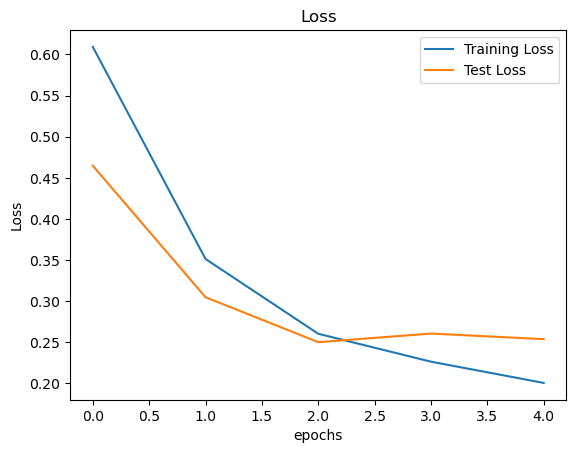

In [21]:
plot_training_data("Loss", train_loss_array, valid_loss_array)

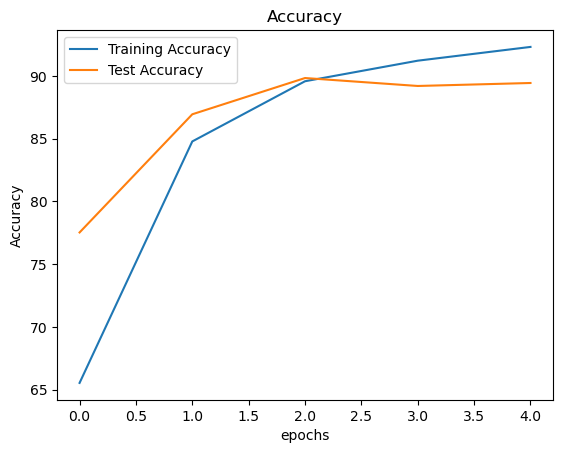

In [22]:
plot_training_data("Accuracy", train_accuracy_array, valid_accuracy_array)

## On sauvegarde nos poids

In [23]:
ckpt = {
    "state_dict": model.state_dict(),
    "config": {
        "emb": EMBEDDING_LAYER,
        "hid": HIDDEN_LAYER,
        "bidirectional": True
    },
    "tokenizer_name": "o200k_base",
    "pad_id": PAD_ID,
    "vocab_size": tokenizer.n_vocab
}

torch.save(ckpt, "sent_lstm.ckpt")


## Utilisation de notre modèle pour faire des prédictions

In [24]:
def load_sentiment_model(ckpt_path="sent_lstm.ckpt", device=DEVICE):
    ckpt = torch.load(ckpt_path, map_location=device)
    tokenizer = tiktoken.get_encoding(ckpt["tokenizer_name"])
    model = SentimentLSTM(vocab_size=ckpt["vocab_size"], pad_id=ckpt["pad_id"], **ckpt["config"]).to(device)

    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    return model, tokenizer, ckpt["pad_id"]


In [ ]:
def make_predictor(ckpt="sent_lstm.ckpt"):
    model, tokenizer, pad_id = load_sentiment_model(ckpt)
    def _predict(text, max_length=MAX_LENGTH, threshold=0.5):
        token_ids = tokenizer.encode(text)[:max_length]
        seq_lengths = torch.tensor([len(token_ids)], device=DEVICE)
        padded_ids = torch.tensor(token_ids + [pad_id]*(max_length-len(token_ids)), device=DEVICE).unsqueeze(0)
        with torch.inference_mode():
            prob = torch.sigmoid(model(padded_ids, seq_lengths)).item()
            label = "👍 positive" if prob >= threshold else "👎 negative"
        return label, round(prob,2)
    return _predict

predict_sentiment = make_predictor()

In [26]:
predict_sentiment("That plot twist slapped harder than my rent.")

('👎 negative', 0.15)

In [27]:
predict_sentiment("I’d rather eat a keyboard than rewatch this.")

('👎 negative', 0.12)

In [28]:
predict_sentiment("It is the best movie I ever seen !")

('👍 positive', 0.97)

In [29]:
predict_sentiment("The story was basic, and the direction academic, but it was still good entertainment.")

('👍 positive', 0.97)

In [30]:
predict_sentiment("Despite good photography, it is not the film of the century.")

('👍 positive', 0.83)

## Evaluation final avec les données de test

In [31]:
# build (token_ids, length, label) triples
test_text, test_label = imdb["test"]["text"], imdb["test"]["label"]
test_pairs = [(encode(sequence)) + (label,) for sequence, label in zip(test_text, test_label)]

# loader (same batch size / collate)
test_loader = DataLoader(test_pairs, batch_size=32, shuffle=False, collate_fn=collate)

# evaluate
test_loss, test_acc = test_step(
    model=model,
    dataloader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=DEVICE
)

print(f"\nIMDb official test | loss {test_loss:.4f} | acc {test_acc:.2f}%")


Test loss: 0.27273 | Test accuracy: 88.92%


IMDb official test | loss 0.2727 | acc 88.92%
